<a href="https://colab.research.google.com/github/pajonnakuti/pyDataviz/blob/main/Bathymetry3D_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install cartopy

In [45]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


In [46]:
# === Load dataset ===
ds = xr.open_dataset("/content/drive/MyDrive/PyDataViz/bathymetry.nc")

# Print dataset info
print("\n=== Dataset Diagnostics ===")
print(f"Lon range: {ds.lon.min().values} ? {ds.lon.max().values} (size={ds.lon.size})")
print(f"Lat range: {ds.lat.min().values} ? {ds.lat.max().values} (size={ds.lat.size})")
print("============================\n")


=== Dataset Diagnostics ===
Lon range: -179.9041666667 ? 179.8958333333 (size=1800)
Lat range: -89.8958333333 ? 89.9041666667 (size=900)



In [47]:
# Subset safely using .where (works even if coords not strictly monotonic)
subset = ds.where(
    (ds.lon >= 30) & (ds.lon <= 120) &
    (ds.lat >= -60) & (ds.lat <= 30),
    drop=True
)

print(f"Subset dimensions: lon={subset.lon.size}, lat={subset.lat.size}\n")

Subset dimensions: lon=450, lat=450



In [48]:
lon = subset['lon'].values
lat = subset['lat'].values
bathymetry = subset['bathymetry'].values


In [49]:
# Mask land (NaN where bathy >= 0)
bathymetry_masked = np.where(bathymetry < 0, bathymetry, np.nan)

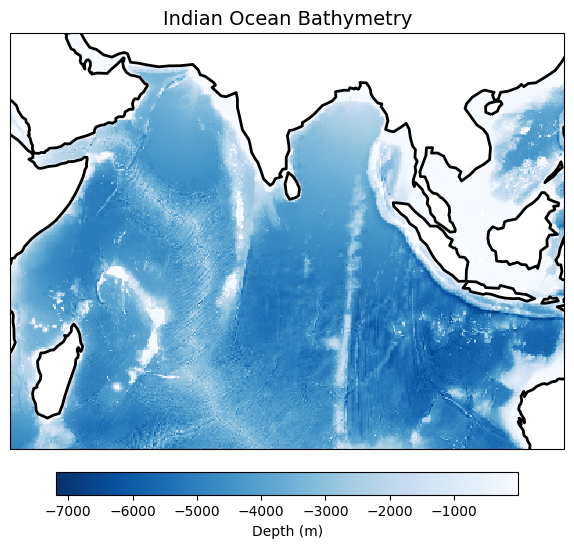

In [51]:
# === Plot 2D Bathymetry ===
Lon, Lat = np.meshgrid(lon, lat)
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
p = ax.pcolormesh(Lon, Lat, bathymetry_masked, cmap="Blues_r", shading="auto")

# Coastlines
ax.coastlines(resolution="110m", color="black", linewidth=2)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor="black")  # optional

# Map extent
ax.set_extent([40, 120, -30, 30], crs=ccrs.PlateCarree())
ax.set_title("Indian Ocean Bathymetry", fontsize=14)

# Colorbar
cb = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05, fraction=0.05)
cb.set_label("Depth (m)")

plt.show()

In [52]:
import numpy as np
import plotly.graph_objects as go
import cartopy.feature as cfeature
import shapely.geometry as sgeom

In [53]:
# Meshgrid
Lon, Lat = np.meshgrid(lon, lat)

In [54]:
# Subsample for speed
step = 3
Lon = Lon[::step, ::step]
Lat = Lat[::step, ::step]
Bathy = bathymetry[::step, ::step]

In [55]:
# Separate ocean and land
Ocean = np.where(Bathy < 0, -Bathy, np.nan)   # flip sign for depth
Land  = np.where(Bathy >= 0, 0, np.nan)       # flat at 0m

In [56]:
fig = go.Figure()
# Ocean surface (colored by depth)
fig.add_trace(go.Surface(
    x=Lon, y=Lat, z=Ocean,
    colorscale="Jet",      # use Jet-like scheme
    cmin=0, cmax=7000,
    showscale=True,
    opacity=0.95,
    name="Ocean Depth"
))

# Land surface (flat brown)
fig.add_trace(go.Surface(
    x=Lon, y=Lat, z=Land,
    surfacecolor=np.zeros_like(Land),
    colorscale=[[0, "saddlebrown"], [1, "saddlebrown"]],
    showscale=False,
    opacity=1.0,
    name="Land"
))

# Add coastlines at z=0
coast = cfeature.NaturalEarthFeature(
    category="physical", name="coastline", scale="110m"
)
for geom in coast.geometries():
    if isinstance(geom, sgeom.LineString):
        x, y = geom.xy
        fig.add_trace(go.Scatter3d(
            x=list(x), y=list(y), z=[0]*len(x),
            mode="lines",
            line=dict(color="black", width=3),
            name="Coastline"
        ))
    elif isinstance(geom, sgeom.MultiLineString):
        for line in geom:
            x, y = line.xy
            fig.add_trace(go.Scatter3d(
                x=list(x), y=list(y), z=[0]*len(x),
                mode="lines",
                line=dict(color="black", width=3),
                name="Coastline"
            ))

# Layout
fig.update_layout(
    title="3D Bathymetry with Land & Coastlines",
    scene=dict(
        xaxis_title="Longitude",
        yaxis_title="Latitude",
        zaxis_title="Depth (m)",
        zaxis=dict(autorange="reversed", range=[-7000, 100])  # ocean convention
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


In [43]:
import numpy as np
import plotly.graph_objects as go

x = np.linspace(-60, 60, 200)
y = np.linspace(-60, 60, 200)
X, Y = np.meshgrid(x, y)
Z = -4000 + 1000*np.exp(-0.001*(X**2 + Y**2))  # Simulated seamount

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale="Viridis")])
fig.update_layout(title="3D Bathymetry (Synthetic Seamount)",
                  scene=dict(zaxis=dict(title="Depth (m)", autorange="reversed")))
fig.show()


In [5]:
# === Load dataset ===
import requests

url = "https://github.com/pajonnakuti/pyDataviz/raw/17951688c7b035d1cdbbbd0f007ab46f49b11985/data/bathymetry.nc"
response = requests.get(url)
with open("bathymetry.nc", "wb") as f:
    f.write(response.content)

ds = xr.open_dataset("bathymetry.nc")
print(ds)
lon = ds['lon'].values
lat = ds['lat'].values
bath = ds['bathymetry'].values.T   # transpose because (lon, lat)

<xarray.Dataset> Size: 13MB
Dimensions:     (lat: 900, lon: 1800)
Coordinates:
  * lon         (lon) float64 14kB -179.9 -179.7 -179.5 ... 179.5 179.7 179.9
  * lat         (lat) float64 7kB -89.9 -89.7 -89.5 -89.3 ... 89.5 89.7 89.9
Data variables:
    bathymetry  (lat, lon) float64 13MB ...
Attributes:
    Author:         Dr. Siva Srinivas Kolukula
    creation_date:  13-Jan-2016 12:36:55


In [59]:
import xarray as xr
import plotly.graph_objects as go
import numpy as np
import cartopy.feature as cfeature

# === Load the NetCDF bathymetry file ===
ds = xr.open_dataset("bathymetry.nc")

lon = ds['lon'].values
lat = ds['lat'].values
bathymetry = ds['bathymetry'].values  # shape (lon, lat)



# === Create meshgrid ===
Lon, Lat = np.meshgrid(lon, lat, indexing="xy")

# Downsample for speed
step = 5
Lon = Lon[::step, ::step]
Lat = Lat[::step, ::step]
bathymetry = bathymetry[::step, ::step]

# === Get coastline from Natural Earth via Cartopy ===
coastline = cfeature.NaturalEarthFeature(
    category='physical',
    name='coastline',
    scale='110m'
)

# Extract coastlines
coast_lines = []
for geom in coastline.geometries():
    if geom.geom_type == "LineString":
        x, y = geom.xy
        coast_lines.append((np.array(x), np.array(y)))
    elif geom.geom_type == "MultiLineString":
        for line in geom:
            x, y = line.xy
            coast_lines.append((np.array(x), np.array(y)))

# === Build Plotly Figure ===
fig = go.Figure()

# Bathymetry surface
fig.add_trace(go.Surface(
    x=Lon,
    y=Lat,
    z=-bathymetry,   # depth positive downward
    colorscale="Viridis",
    cmin=-6000, cmax=0,
    showscale=True
))

# Coastline (z=0)
for x, y in coast_lines:
    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=np.zeros_like(x),  # z=0 for all coastline points
        mode="lines",
        line=dict(color="black", width=2),

    ))

fig.update_layout(
    title="3D Bathymetry with Coastline",
    scene=dict(
        xaxis_title="Longitude",
        yaxis_title="Latitude",
        zaxis_title="Depth (m)",
        zaxis=dict(autorange="reversed")  # ocean downward
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()
